<a href="https://colab.research.google.com/github/velocirobbie/Materials_AI_colab/blob/master/Stress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook based on 'Intro to TensorFlow and Music Generation with RNNs'

# Stress tensor prediction with RNNs


## 0 Notes

### 0.1 Done...

- Modify the features and target list:
  - ~use current strain and previous stress to predict current stress~
    - not efficient, the RNN gives simply too much weight to the previous stress, as its value is always *in the same range* as the current stress
  - ~normalise correctly each column (see tutorial)~

### 0.2 TODO

#### 0.2.1 To be tested with the toy model
- Optimisation of the NN
  - use single current estimates (FFNN) or trajectories (RNN) of the features
  - Modify the features and target list:
    - in short, what Wouter does with a couple of lagged values of strain and stress should be fine, or in more details:
      - use $\Delta\underline{\underline{\epsilon}}^{t}, \underline{\underline{\epsilon}}^{t-1}, \underline{\underline{\sigma}}^{t-1}$ as initial features (almost unique target associated with these features, except at hysteresis interesection points)
      - add $\Delta\underline{\underline{\epsilon}}^{t-1}, \Delta\underline{\underline{\sigma}}^{t-1}$ as features, to ensure uniqueness at hysteresis intersection points (or derive tanget stiffness tensor)
      - a few time steps strains (lagged values) should be enough to ensure uniqueness (no point in the space $(\Delta\underline{\underline{\epsilon}}^{t}, \underline{\underline{\epsilon}}^{t-1}, \underline{\underline{\sigma}}^{t-1}, \underline{\underline{\epsilon}}^{t-2}, \underline{\underline{\sigma}}^{t-2})$ has the same $\underline{\underline{\sigma}}^{t}$
        - RNNs are particularly suited for that problem!
    - use stress or stress increment as target
    - use complete tensors
      - see this [paper](https://doi.org/10.1016/j.cma.2020.112875) to make use of invariances
  - Test the influence of the length of sequences on the prediction
    - RNN with sequence_length=1 is equivalent to ANN
  - Smoothing molecular dynamics strain/stress curves (to be used as inputs)
  - Optimisation of hyperparameters of the RNN
  - Add Physics-Informed regularisation (e.g. verify conservation laws, ensure growth of entropy $\dot{S} > 0$)
     - either directly as a regularisation or as a final layer in the NN
  - Add numerical constraints for stability (within the expression of the loss function as suggested by Jing)
    - avoid for example, $\frac{\Delta\sigma}{\Delta\epsilon}=0$
  - predict a stress distribution rather than a deterministic value
    - could assume that the molecular model outputs a stress distribution (over time and replicas), not just an averaged value
    - this holds within the framework suggested by Wouter
    - this will free us from the assumption that we can consider only the mean value of that distribution, which might actually be unlikely if the stress distribution is not Gaussian.
    - we can start the study by checking the distribution shape of the stress, is it Gaussian?

- Initial training of the NN
 - Training on data produced by a first  multiscale simulation, sampling is driven by the continuum model depending on its parameters
 - Training on data produced by sampling of the parameter space
  - MC, qMC, PCE?
  - strain and stress are correlated, any stress/strain couple is not valid

- Active or adaptative learning
  - Evaluate *a priori* accuracy of prediction on unseen data
    - PAC-Bayes? 
    - Distance to training data in the features space?
      - that's exactly what the clustering algorithm does! the tolerance would be bigger if
        - we were able to interpolate (NN)
        - we restrained the parameter space (features limited to $ \Delta\underline{\underline{\epsilon}}^{t}, \underline{\underline{\epsilon}}^{t-1}, \underline{\underline{\sigma}}^{t-1}$)
  - Request new training data when accuracy is too low
    - see section 4.5.2 of this [paper](https://www.sciencedirect.com/science/article/pii/S0045782511001290#b0185)
    - How do you generate the data point for a given strain/stress couple? it cannot be access directly using the molecular model, the stress itself depends on the strain trajectory.
  - Or... the surrogate rather has to earn its independence (online coupled learning from [Rasp, 2019](https://arxiv.org/abs/1907.01351))
    - keep asking for new high-resolution data, until the predictions of the surrogate are accurate enough




#### 0.2.2 To do for UQP#3
(things to do for the application of the RNN as a surrogate model for semi-intrusive UQ)

- Implement training and testing of the RNN within SCEMa (UQP3-B)
  - training on a previous run of SCEMa (with molecular parameters constant)
  - perform UQ of continuum parameters replacing the molecular model with the surrogate model
- Validate predictions of the surrogate model on data from alternate SCEMa simulations:
  - keeping all molecular parameters constant, but changing continuum parameters (sort of second-order variation)
  - changing also molecular parameters



### 0.2.3 To do for EasySurrogate

- Design #1 (for surrogate training):
  - build a surrogate model out of a NN
    - predictor for constitutive behaviour
  - while (surrogate predictions are inaccurate):
    - *note: orchestrate all the following using MUSCLE3*
    - generate distributions of the surrogate input parameters
      - perform low-resolution model complete simulations using closed-form  approximation of the high-resolution model (elastic approximation of the constitutive behaviour)
    - generate a campaign using EasyVVUQ sampling the input parameter distribution using qMC
       - reduce campaign size of microscale simulations as accuracy of surrogate increases
    - generate training data by executing multiple simulations using FabSim
      - keep track of high-resolution model parameter configurations associated with surrogate input parameters
    - test accuracy of surrogate on new generated data
    - train the surrogate model

- Design #2 (for UQ):
*note: this [tutorial](https://machinelearningmastery.com/what-is-bayesian-optimization/) can be used for this design; instead of using BFGS or random or grid search for samples, the continuum model is used here; then Probability of Improvement can be used to select best samples to simulate withe the molecular model (the objective function); hopefully, a NN (like the GPR) can allow to estimate the expected improvement.*
  - build a surrogate model out of a NN
    - predictor for constitutive behaviour
  - while (all parameter configurations of the macroscopic model are not simulated):
    - *note: orchestrate all the following using MUSCLE3*
    - advance macroscopic model simulation (continuum) 
      - sample the input parameter space
      - coarsen sampling with surrogate accuracy increase
    - generate a campaign using EasyVVUQ 
    - generate training data by executing multiple simulations using FabSim
      - keep track of high-resolution model parameter configurations associated with surrogate input parameters
    - verify predictions of the surrogate
    - update training of the surrogate
    - finish advancing the low-resolution model (continuum)

## 1 Design of the RNN

### 1.1 Comments on the use of an RNN for text generation

In text generation, a RNN is used to predict the upcoming character following a given sequence of characters of length $t$. 

In the reading phase, the input of the RNN is a character of the given sequence. And in the generation phase, the input becomes the output of the previous iteration (or time step).

<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png" alt="LSTM inference" height="300px"/>

At a given iteration, in the generation phase, the RNN cell is then reusing two pieces of information from the previous time step: the updated internal state of the RNN cell (usually denoted $h$) and the generated output:

### 1.2 The function we are trying to generate with ML

Here is the function $\bar{f}$ that gives us the current stress $\underline{\underline{\sigma}}^t$ as a function of the strain trajectory $(\underline{\underline{\epsilon}}^0,...,\underline{\underline{\epsilon}}^t)$ for a given material in its initial configuration $\underline{u}^{0}$:

$\underline{\underline{\sigma}}^t = f\left(\underline{u}^{t-1}, \underline{\underline{\epsilon}}^t\right)$

with $\underline{u}^{t-1} = h\left(\underline{u}^{t-2},\underline{\underline{\epsilon}}^{t-2}\right)$

then $\underline{\underline{\sigma}}^t = \bar{f}(\underline{u}^0,\underline{\underline{\epsilon}}^0,...,\underline{\underline{\epsilon}}^t)$  ($= \bar{f}(\underline{\underline{\epsilon}}^0,...,\underline{\underline{\epsilon}}^t)$, for a given material)

In a first implementation, we tried instead:
$$
\begin{aligned}
\underline{\underline{\sigma}}^t 
&= \bar{f}(\underline{u}^0,\underline{\underline{\epsilon}}^0,...,\underline{\underline{\epsilon}}^t, \underline{\underline{\sigma}}^0,...,\underline{\underline{\sigma}}^{t-1}) \\
&= \bar{f}_{RNN}(\underline{\underline{\epsilon}}^t, \underline{\underline{\sigma}}^{t-1})
\end{aligned}
$$


But what would more accurate but as generically valid:
$$
\begin{aligned}
\Delta\underline{\underline{\sigma}}^t 
&= \bar{f}_{RNN}(\underline{\underline{\epsilon}}^t, \underline{\underline{\sigma}}^{t-1}, \Delta\underline{\underline{\epsilon}}^t) \\
\end{aligned}
$$




### 1.3 Constitutive modelling with RNNs

Translating this to our mechanical problem, we want to predict the upcoming stress $\sigma^{T}$, following a sequence of stresses $(\sigma^{0},...,\sigma^{T-1})$. In result, a training data sample would consist of two sequences of stresses.

In input, the $\sigma$ sequence up to the previous timestep $T-1$ of a certain quadrature point $p$:

$x^{p,T}_{input} =
\begin{bmatrix}
 \sigma^{p,0}_{11} & \sigma^{p,1}_{11} & \cdots & \sigma^{p,T-1}_{11}
\end{bmatrix}_{(T)}
$

and, in output, this same $\sigma$ sequence, but offset by one time step (removing the never predicted $\sigma^{0}$ and including $\sigma^{T}$):

$y^{p,T}_{output} =
\begin{bmatrix}
 \sigma^{p,1}_{11} & \sigma^{p,2}_{11} & \cdots & \sigma^{p,T}_{11}
\end{bmatrix}_{(T)}
$

The RNN will generate a prediction of $\tilde{\sigma}^{t}$, after reading each $\sigma^{t-1}$ of the input sequence. In turn, we can assess the efficiency of the RNN by comparing for each index $t$ of the sequences the difference between $\tilde{\sigma}^{t}$ and $\sigma^{t}$.

But we can do better, we have additional knowledge to use to make our prediction of the $\sigma^{T}$ more accurate, we can provide the current strain $\epsilon^{T}$ as a second feature, the input data then becomes: 

$x^{p,T}_{sample} =
\begin{bmatrix}
 \epsilon^{p,1}_{11} & \epsilon^{p,2}_{11} & \cdots & \epsilon^{p,T}_{11}\\
 \sigma^{p,0}_{11} & \sigma^{p,1}_{11} & \cdots &\sigma^{p,T-1}_{11}
\end{bmatrix}_{(T\times2)}$

One might argue that the previous stress $\sigma^{t-1}$ is not needed as an input of the RNN model, as it is already accounted once. Indeed, the internal state of the RNN cell $h$, is preserved from one time step to another. Yet, we have seen with text generating RNNs that this redundancy of information is necessary. As discussed in the previous section, in the reading phase, the RNN cell needs to use as an input the actual previous character (or here $\sigma^{t-1}$) to predict the next one (here $\sigma^{t}$), not simply its internal state $h^{t-1}$ updated predicting of the previous stress $\tilde{\sigma}^{t-1}$. Otherwise, the RNN model would be purely be generating a sequence of stresses from a given stress initialisation, but not generating stresses from an actual sequence of stresses.

## 2 Dependencies 
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [0]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Import all remaining packages
import numpy as np
import pandas as pd
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

# Import packages (and setup) for plots
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

# Try to allocate some TPUs

## 3 Generation of the datasets

Let's import the dataset we have formerly used for the clustering algorithm as well as Dongwei's CNN training and testing. We start with a 1D example, that is we only consider axial components of the strain and stress tensors ($\epsilon_{11}$ and $\sigma_{11}$).


### 3.1 Importing files and data

First we build a function `load_proc_datafile` that parses one CSV data file generated by SCEMa (e.g `pr_X.lhistory.csv`). The data file contains the strain and stress tensors at each time step of the simulation for the quadrature points of the FE cells associated by the rank `X` during the simulation.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_proc_datafile(number_file):
    file_name = 'https://raw.githubusercontent.com/velocirobbie/Materials_AI_colab/master/datasets/pr_{}.lhistory.csv'.format(number_file)
    #file_name = '/content/drive/My Drive/UCL: Multiscale properties of Nanocomposites/SCEMa/Surrogate Modelling/ms_proc_dataset/pr_{}.lhistory.csv'.format(number_file)
    data_pd = pd.read_csv(file_name)
    data_list = data_pd.values
    # insert first column with unique cell/qp ID (cqid): cell*8+q
    data_list = np.insert(data_list, 0, data_list[:,1]*8+data_list[:,2], axis=1)
    # sort by cqid then timestep
    data_list = data_list[np.lexsort((data_list[:, 1], data_list[:, 0]))]
    # Building empty containers for the current input (x) and output (y) data
    T = np.max(data_list[:,1])
    nqps = np.size(np.unique(data_list[:,0]))
    return data_list, nqps, T

The functions `generate_input_batch` and `generate_output_batch` format the data for the training phase of the RNN model for $N_{qps}$ quadrature points at a given timestep $T$. Returning the following input and target arrays:

$x^{file}_{batch} =
\begin{bmatrix}
\begin{bmatrix}
 \epsilon^{1,1}_{11}  & \epsilon^{1,2}_{11} & \cdots & \epsilon^{1,T}_{11} \\
  \sigma^{1,0}_{11}  & \sigma^{1,1}_{11} & \cdots & \sigma^{1,T-1}_{11}
 \end{bmatrix}_{(T \times 2)}\\
\begin{bmatrix}
 \epsilon^{2,1}_{11}  & \epsilon^{2,2}_{11} & \cdots & \epsilon^{2,T}_{11} \\
  \sigma^{2,0}_{11}  & \sigma^{2,1}_{11} & \cdots & \sigma^{2,T-1}_{11}
 \end{bmatrix}_{(T \times 2)}\\
 %\vdots  & \vdots  & \vdots  & \vdots  & \ddots & \vdots & \vdots  \\
\begin{bmatrix}
 \epsilon^{N_{qps},1}_{11}  & \epsilon^{N_{qps},2}_{11} & \cdots & \epsilon^{N_{qps},T}_{11} \\
  \sigma^{N_{qps},0}_{11}  & \sigma^{N_{qps},1}_{11} & \cdots & \sigma^{N_{qps},T-1}_{11}
 \end{bmatrix}_{(T \times 2)}
\end{bmatrix}_{(N_{qps}\times T \times 2)}
$
$y^{file}_{batch} =
\begin{bmatrix}
 \sigma^{1,1}_{11} & \sigma^{1,2}_{11} & \cdots & \sigma^{1,T}_{11} \\
 \sigma^{2,1}_{11} & \sigma^{2,2}_{11} & \cdots & \sigma^{2,T}_{11} \\
 \vdots  & \vdots  & \ddots & \vdots  \\
 \sigma^{N_{qps},1}_{11} & \sigma^{N_{qps},2}_{11} & \cdots & \sigma^{N_{qps},T}_{11} \\
\end{bmatrix}_{(N_{qps}\times T)}
$

Loading complete data for withing each rank file, only selecting the components of the strain and stress tensor of interest.

In [0]:
def generate_subdataset(data_list, nqps, T, strain_components=[1], stress_components=[1]):
    # the number of rows is the number of QPs (nqps), and note that 'T' is the number of timesteps, or the current timestep.
    subdataset = np.empty([nqps,T,len(strain_components)+len(stress_components)])
    nq = 0 # current row number in 'samples_data_x'
    # Loop over rows in 'data_list'
    for j in range(np.size(data_list[:,0])):
      cqid = data_list[j,0]
      time = data_list[j,1]
      # skip the first timestep for each quadrature point, then start building
      # the mechanical state trajectory
      features_list = []
      for component in strain_components:
        features_list.append(data_list[j,4+component])
      for component in stress_components:
        features_list.append(data_list[j,-7+component])

      if time == 1:
        qp_ms_traj = np.array([features_list])
      elif time > 1:
        qp_ms_traj = np.append(qp_ms_traj,[features_list], axis=0)
      # check the id of the quadrature point at the next row
      try:
        next_cqid = data_list[j+1,0]
      except:
        next_cqid = -1 # set it to -1 if arriving at the end of the data
      # if the next id is different to the current one, then building the 
      # trajectory of the current quadrature point is complete
      if next_cqid != cqid:
        subdataset[nq,:,:] = qp_ms_traj
        nq+=1
    return subdataset

In [0]:
def generate_fulldataset_from_file_range(file_range, strain_components=[1], stress_components=[1]):
  # Total number of trajectories loaded (or total number of quadrature points)
  nqps_tot = 0
  first_iter = True

  # Generate training data
  for i in file_range:
      # Reading data from the file generated by a given rank during the simulation of the finite element model 
      data_list_file , nqps, T = load_proc_datafile(i)
      nqps_tot += nqps

      # Parsing "slightly" the data from the rank and splitting it into input and output datasets
      # TODO: Try to use the strain as a second feature, and then maybe use the whole tensor
      subdataset = generate_subdataset(data_list_file, nqps, T, strain_components, stress_components) 

      # Assembling the datasets for the ML model
      if first_iter:
        ### loading strain data (N steps of 6-components) into train_X for each qp of each cell at every timestep
        dataset = subdataset
        first_iter = False
      else:
        ### continuing identlically to load the data for the subsequent files
        dataset = np.append(dataset,subdataset,axis=0)
      
  # Checking the length of the rows of the generated data samples
  assert np.shape(dataset)[1] == (T), "The length of the rows of train_X ({}) does not agree with the current timestep ({})".format(np.shape(X)[1],T)

  # Checking the length of the columns
  assert np.shape(dataset)[0] == nqps_tot, "The length of the columns of train_X ({}) does not agree with the total number of qps parsed".format(np.shape(X)[0],nqps_tot)

  return dataset, nqps_tot, T

In [0]:
# Generating training and testing datasets from different simulation data files
strain_components = [4] # 1:xx, 2:xy, 3:xz, 4:yy, 5:yz, 6:zz
stress_components = [4] # 1:xx, 2:xy, 3:xz, 4:yy, 5:yz, 6:zz

file_range_data = np.arange(1,3) # [1,2,3,...,N_train]
fulldataset, nqps_tot_data, T_data = generate_fulldataset_from_file_range(file_range_data, strain_components, stress_components)

In [0]:
print(fulldataset.shape, nqps_tot_data, T_data)

(3776, 195, 2) 3776 195


Adding time differences as variables to the dataset.

In [0]:
fulldataset_wgrads = np.append(fulldataset, 
                        np.gradient(fulldataset, axis=1), 
                        axis=2)

assert fulldataset_wgrads.shape[2] == 2*fulldataset.shape[2], "The number of variables (features+targets) should have doubled after including their time differences (gradients)"
print(fulldataset_wgrads.shape)

(152, 195, 4)


Adding shifted data and forgetting first timestep.

In [0]:
fulldataset_wgrads_wshift = np.append(fulldataset_wgrads, 
                                      np.roll(fulldataset_wgrads,shift=1,axis=1), 
                                      axis=2)[:,1:,:]
                        
assert fulldataset_wgrads_wshift.shape[2] == 2*fulldataset_wgrads.shape[2], "The number of variables (features+targets) should have doubled after including their time differences (gradients)"
print(fulldataset_wgrads_wshift.shape)

(152, 194, 8)


Selecting features and targets.

The third dimension of the dataset is order as:
$\underline{\underline{\epsilon}}^{t}, \underline{\underline{\sigma}}^{t}, \Delta\underline{\underline{\epsilon}}^{t}, \Delta\underline{\underline{\sigma}}^{t}, \underline{\underline{\epsilon}}^{t-1}, \underline{\underline{\sigma}}^{t-1}, \Delta\underline{\underline{\epsilon}}^{t-1}, \Delta\underline{\underline{\sigma}}^{t-1}$



In [0]:
# strain_t-1, stress_t-1, delta_strain_t
features_list = [4,5,2]
X = fulldataset_wgrads_wshift[:,:,features_list]

# delta_stress_t
targets_list = [3]
y = fulldataset_wgrads_wshift[:,:,targets_list]
print(X.shape, y.shape)

(152, 194, 3) (152, 194, 1)


Splitting into training and testing.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(101, 194, 3) (51, 194, 3) (101, 194, 1) (51, 194, 1)


### 3.2 Visualisation of the data

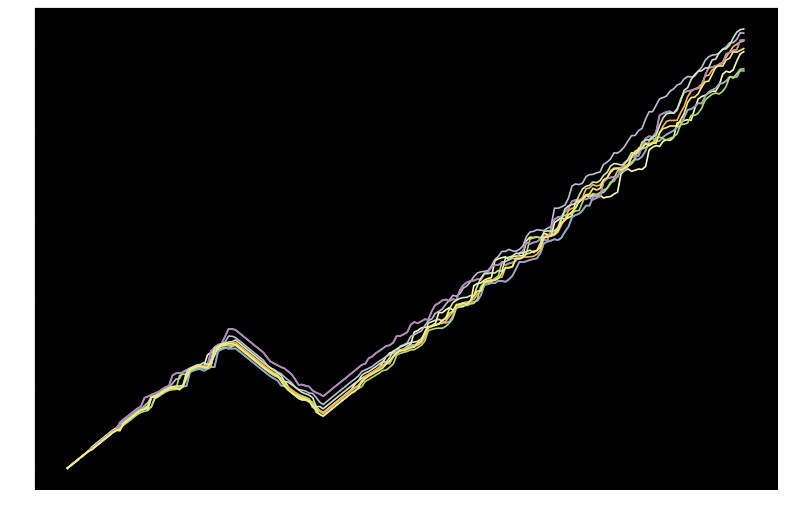

In [0]:
fig = plt.figure(figsize=(12, 8), dpi= 80)
ax = plt.axes()

# Plot the stress series for the first five quadrature points
plt.plot(X_train[:10,:,0].T)

### 3.3 Normalisation of data

As indicated by this [post](https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/): "*Some algorithms, such as neural networks, prefer data to be standardized and/or normalized prior to modeling.*"

Normalisation in presence of multiple features avoids that some features with high magnitude influence preferably the optimisation of the weights.

Zero-mean of the stress values distribution (at a given time step?) enables to have increasing and decreasing weights during a single training iteration.

In [0]:
# Perform normalisation per quadrature point (and also per feature, of course...)
from sklearn.preprocessing import MinMaxScaler

def normalise_dataset(dataset):
  dataset_normalised = np.empty(dataset.shape)

  normaliser = []
  for qp in np.arange(dataset.shape[0]):
    normaliser.append(MinMaxScaler())
    normaliser[qp].fit(dataset[qp,:,:])
    dataset_normalised[qp,:,:] = normaliser[qp].transform(dataset[qp,:,:])

  return dataset_normalised, normaliser

# To be used as: X_train_denorm = denormalise_dataset(X_train_norm, X_train_normaliser)
def denormalise_dataset(dataset_normalised, normaliser):
  dataset = np.empty(dataset_normalised.shape)

  for qp in np.arange(dataset_normalised.shape[0]):
    dataset[qp,:,:] = normaliser[qp].inverse_transform(dataset_normalised[qp,:,:])

  return dataset

In [0]:
# Normalise each dataset independently
X_norm, X_normaliser = normalise_dataset(X)
y_norm, y_normaliser = normalise_dataset(y)
X_train_norm, X_train_normaliser = normalise_dataset(X_train)
y_train_norm, y_train_normaliser = normalise_dataset(y_train)
X_test_norm, X_test_normaliser = normalise_dataset(X_test)
y_test_norm, y_test_normaliser = normalise_dataset(y_test)

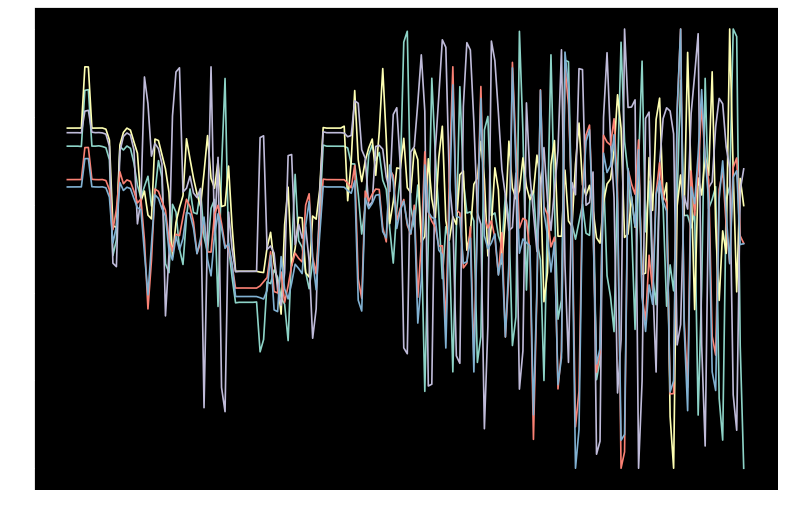

In [0]:
fig = plt.figure(figsize=(12, 8), dpi= 80)
ax = plt.axes()

# Plot the stress series for the first five quadrature points
plt.plot(y_train_norm[:5,:,0].T)

### 3.4 Box-Cox transform for stationary Variance

Quite useless here...

In [0]:
# example of power transform and inversion
from math import log
from math import exp
from scipy.stats import boxcox
 
# invert a boxcox transform for one value
def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

# Power transform of the data
a_time_series = X_train_norm[0,:,0]

transformed_time_series, lmbda = boxcox(a_time_series)

fig, ax = plt.subplots(2, figsize=(12, 8), dpi= 80)

# Plot the stress series for the first five quadrature points
ax[0].plot(a_time_series)
ax[1].plot(transformed_time_series)

ValueError: ignored

## 4 Definition of the RNN model

### 4.1 Building the model

We now generate the RNN model using the Keras library.

The RNN model used in the MIT tutorial is more complex than the simplest version possible, on several points:
- The Embedding layer (which I don't understand the role, I only understand its mapping capability from char to int)
- The Dense layer does not output a single music note (as int), but a probability distribution of the output note (probability associated which each existing music note).

Following what is done [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/), we implement a Multiple Input LSTM, that is one LSTM layer and one Dense layer.

We want to start with a simpler version, which predicts the current stress (`n_targets = 1`) from the previous stress (as with any time series) and the current strain (`n_features = 2`).

In [0]:
# Defining the RNN Model
def build_model(rnn_units, n_qps, n_steps, n_features, n_targets):
  model = tf.keras.Sequential([
    # Layer 0: Potentially add a Convolutional layer as in ConvLSTM or CNN-LSTM to filter high frequency fluctuations
    # Layer 1: LSTM with `rnn_units` number of units.
    ## Discuss/test the choice of the activation function: do not use ReLU
    ## because stresses can have negative values (which are "cut" by ReLU activation)
    tf.keras.layers.LSTM(rnn_units,
                         recurrent_activation='tanh',
                         return_sequences=True, 
                         #stateful=True, 
                         #batch_input_shape=(n_qps, n_steps, n_features)),
                         input_shape=(n_steps, n_features)
                         ),

    # Layer 2: Dense (fully-connected) layer that transforms the LSTM output into the predicted stress
    #tf.keras.layers.Dense(rnn_units, activation='tanh'),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the predicted stress
    tf.keras.layers.Dense(n_targets)
  ])

  return model

# Build a simple model with default hyperparameters.
model = build_model(rnn_units=50, # TODO: Check the influence of the number of RNN_units
                    n_qps=X_train.shape[0], n_steps=X_train.shape[1], 
                    n_features=X_train.shape[2], n_targets=1)

In [0]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # TODO: Improve optimiser (e.g SGD...)

### 4.2 Verifying the structure of the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 194, 50)           10800     
_________________________________________________________________
dense (Dense)                (None, 194, 1)            51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [0]:
pred = model(X_train)
print("Input shape:      ", X_train.shape, " # (batch_size, sequence_length, features_count)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, target_count)")

Input shape:       (2529, 194, 1)  # (batch_size, sequence_length, features_count)
Prediction shape:  (2529, 194, 1) # (batch_size, sequence_length, target_count)


Let's take a look at what our untrained model is predicting.

In [0]:
# compute the loss using the true next characters from the example batch 
# and the predictions from the untrained model several cells above
example_batch_loss = tf.keras.losses.mean_squared_error(y_train[:,:,:], pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, current_stress)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (2529, 194, 1)  # (batch_size, sequence_length, current_stress)
scalar_loss:       4.070778e+16



## 5 Training the RNN model

First, as done [here](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/) (section 3.3).

In [0]:
%%time
model.fit(X_train_norm, y_train_norm, 
          # X_train_norm, y_train_norm[:,-1,0], # if "return_sequences=False"
          epochs=100,
          verbose=1,
          # batch_size=32, validation_data=(X_test, y_test)
          )

Epoch 1/100
4/4 [==============================] - 1s 298ms/step - loss: 0.3736 - mae: 0.5841
Epoch 2/100
4/4 [==============================] - 1s 280ms/step - loss: 0.3575 - mae: 0.5700
Epoch 3/100
4/4 [==============================] - 1s 284ms/step - loss: 0.3399 - mae: 0.5542
Epoch 4/100
4/4 [==============================] - 1s 287ms/step - loss: 0.3193 - mae: 0.5350
Epoch 5/100
4/4 [==============================] - 1s 299ms/step - loss: 0.2929 - mae: 0.5094
Epoch 6/100
4/4 [==============================] - 1s 290ms/step - loss: 0.2581 - mae: 0.4731
Epoch 7/100
4/4 [==============================] - 1s 293ms/step - loss: 0.2122 - mae: 0.4170
Epoch 8/100
4/4 [==============================] - 1s 287ms/step - loss: 0.2024 - mae: 0.3962
Epoch 9/100
4/4 [==============================] - 1s 302ms/step - loss: 0.1798 - mae: 0.3730
Epoch 10/100
4/4 [==============================] - 1s 292ms/step - loss: 0.1713 - mae: 0.3636
Epoch 11/100
4/4 [==============================] - 1s 306m

In [0]:
mse, mae = model.evaluate(X_test_norm, y_test_norm, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae))

MSE: 0.005, RMSE: 0.074, MAE: 0.060


## 6 Applying the RNN model

### 6.1 Stress prediction
The results are becoming pretty good... without even using the strain as a feature. Note that as the strain is not considered as a feature here, the model is **strain path** dependent!

In [0]:
%%time
# make a prediction
yhat_norm = model.predict(X_test_norm[:,:,:])
print("X_test_norm:",X_test_norm[0,-5:,:].T)
print("y_test_norm:",y_test_norm[0,-5:,:].T)
print("yhat_norm:",yhat_norm[0,-5:,:].T)
print(yhat_norm.shape, y_test_norm.shape)

X_test_norm: [[0.97905827 0.99134814 0.99839417 1.         0.99977361]]
y_test_norm: [[0.91389112 0.6804969  0.71716173 0.71872852 0.72246712]]
yhat_norm: [[0.85106075 0.851856   0.85261726 0.8531696  0.8534701 ]]
(249, 194, 1) (249, 194, 1)
CPU times: user 189 ms, sys: 1.61 ms, total: 190 ms
Wall time: 184 ms


### 6.2 Denormalising data

In [0]:
# Denormalise the data using the previously generated transform
yhat = denormalise_dataset(yhat_norm, y_test_normaliser)
print(yhat.shape,y_test.shape)

(249, 194, 1) (249, 194, 1)


### 6.3 Plotting the prediction

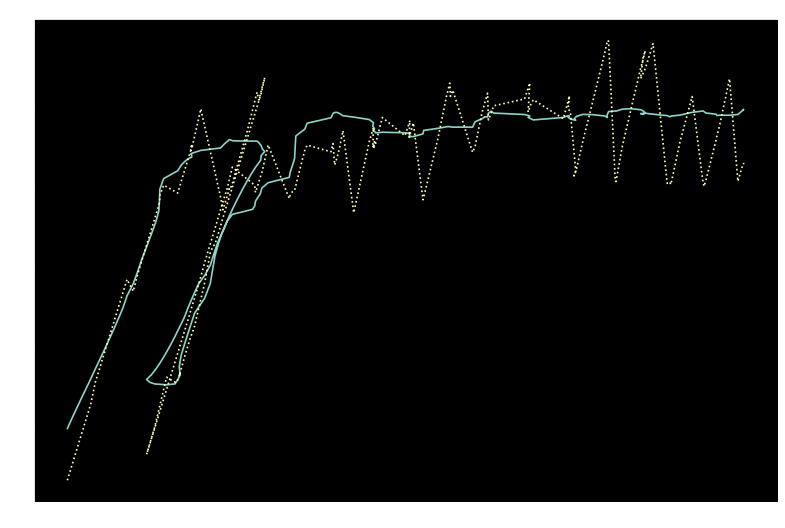

In [0]:
fig = plt.figure(figsize=(12, 8), dpi= 80)
ax = plt.axes()

# Plot the stress series for the first five quadrature points
plt.plot(X_test[0,:,0].T, yhat[0,:,0].T)
plt.plot(X_test[0,:,0].T, y_test[0,:,0].T, linestyle=':')

In [0]:
from sklearn.metrics import r2_score
# R2 score of the correlation plot below
r2_corr = r2_score(y_test.reshape((y_test.shape[0]*y_test.shape[1]*y_test.shape[2])), 
         yhat.reshape((y_test.shape[0]*y_test.shape[1]*y_test.shape[2])))

(194, 249) (194, 249)


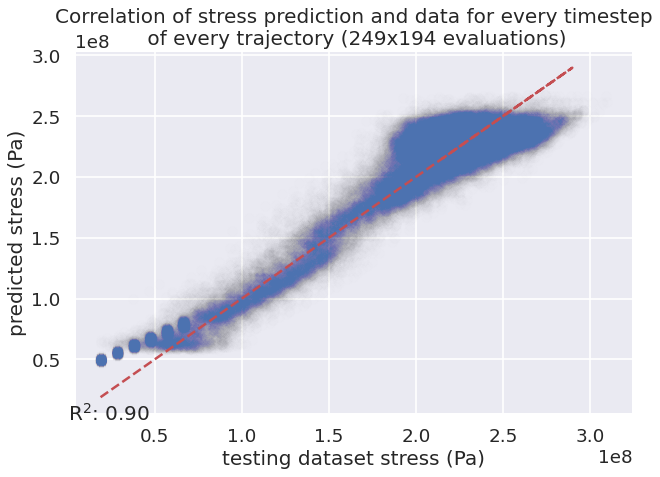

In [0]:
fig = plt.figure(figsize=(9, 6), dpi= 80)
ax = plt.axes(xlabel='testing dataset stress (Pa)', ylabel='predicted stress (Pa)', 
              title="Correlation of stress prediction and data for every timestep\n of every trajectory ({}x{} evaluations)".format(yhat.shape[0],yhat.shape[1]))
print(y_test[:,:,0].T.shape, yhat[:,:,0].T.shape)
plt.text(0.5, 0.5, "R$^2$: {:.2f}".format(r2_corr))
plt.scatter(y_test[:,:,0].T, yhat[:,:,0].T, alpha=0.005)
plt.plot(y_test[0,:,0].T, y_test[0,:,0].T, '--r')


## 7 Evaluating the RNN model

The RNN could be assessed in its ability to predict the stress increment at each timestep rather than the actual stress following [this](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) blog post argument. 

Note, in our case we are always trying to predict $\sigma^{t+1}$ from $\sigma^{t}$ and $\epsilon^{t+1}$. We will always have access to later value of $\epsilon^{t+1}$. Thus, the point of our RNN is indeed to **only** predict the **next** timestep, not the complete future. Hence, $\Delta\sigma^{t+1}$ being the primary focus (not $\sigma^{t+1}$ itself).

### 7.1 Simple checking

In [0]:
# Generating stress increments by differentiation of stress time-series
dy_test = np.diff(y_test, axis=1)
dyhat = np.diff(yhat, axis=1)

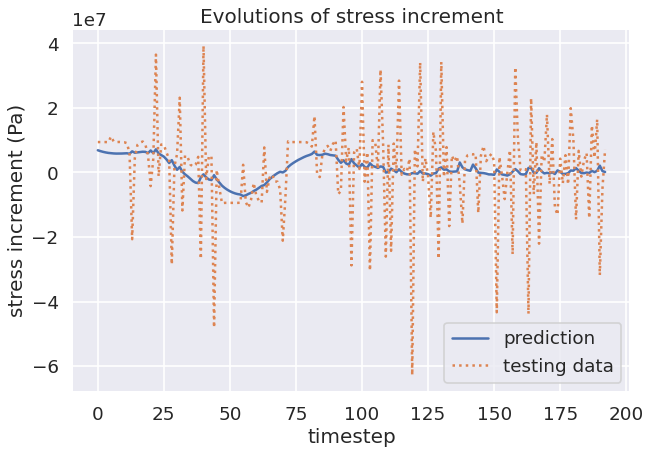

In [0]:
fig = plt.figure(figsize=(9, 6), dpi= 80)
ax = plt.axes(xlabel='timestep', ylabel='stress increment (Pa)', 
              title="Evolutions of stress increment")

plt.plot(dyhat[0,:,0].T, label='prediction')
plt.plot(dy_test[0,:,0].T, linestyle=':', label='testing data')
plt.legend()

(-20000000.0, 20000000.0)

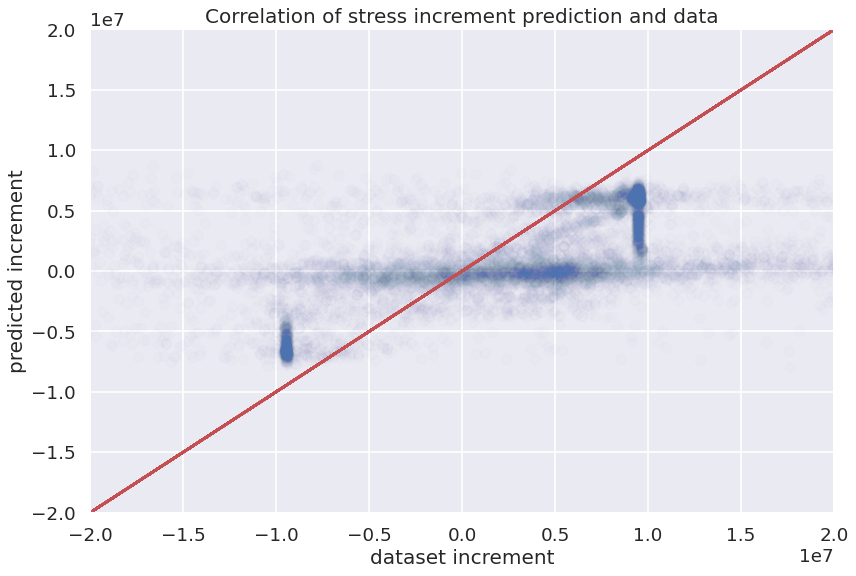

In [0]:
fig = plt.figure(figsize=(12, 8), dpi= 80)
ax = plt.axes(xlabel='dataset increment', ylabel='predicted increment', 
              title="Correlation of stress increment prediction and data")
plt.scatter(dy_test[:,:,0].T, dyhat[:,:,0].T, alpha=0.01)
plt.plot(dy_test[0,:,0].T, dy_test[0,:,0].T, '--r')
plt.xlim((-2e7,2e7))
plt.ylim((-2e7,2e7))

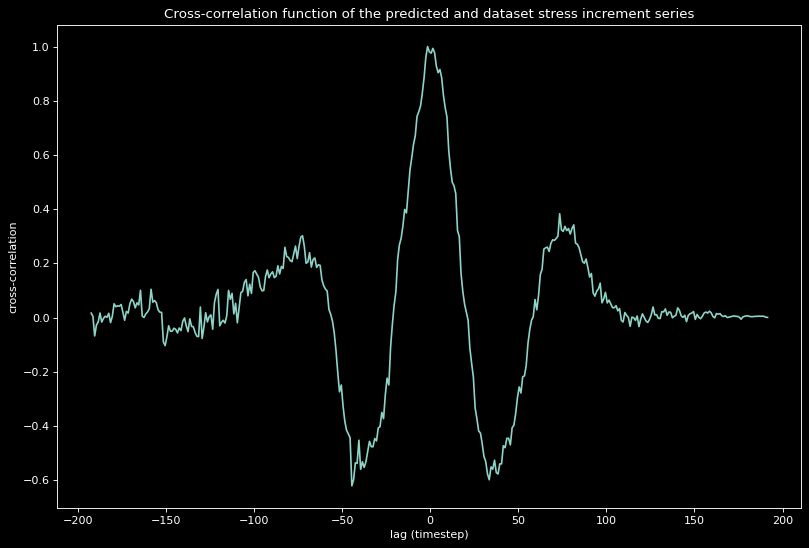

In [0]:
fig = plt.figure(figsize=(12, 8), dpi= 80)
ax = plt.axes(xlabel='lag (timestep)', ylabel='cross-correlation', 
              title="Cross-correlation function of the predicted and dataset stress increment series")

cross_correlation = np.correlate(dyhat[0,:,0], dy_test[0,:,0], mode='full')
lag = np.arange(len(cross_correlation)) - len(cross_correlation)/2
plt.plot(lag, cross_correlation/max(cross_correlation))

### 7.2 Cross-validating

In [0]:
def cross_validate_rnn_given_dataset(X,y,nepochs=10,nfold=5):
  # fix random seed for reproducibility
  seed = 7
  np.random.seed(seed)

  # define 5-fold cross validation test harness
  cvscores = []
  rs = ShuffleSplit(n_splits=nfold, test_size=.25, random_state=seed)
  for train, test in rs.split(X,y):
    # create model
    model = build_model(rnn_units=50,
                        n_qps=X.shape[0], n_steps=X.shape[1],
                        n_features=X.shape[2], n_targets=1)
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    # Fit the model
    model.fit(X[train], y[train], epochs=nepochs, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train_norm[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  return np.mean(cvscores), np.std(cvscores)

## 8 Exploring new strain trajectories

In [0]:
# Generating a new normalised features dataset (new strain trajectory)
X_test_new_norm = np.concatenate([X_test_norm[:,:46,:], X_test_norm[:,98:,:]], axis=1)

In [0]:
# make a prediction
yhat_new_norm = model.predict(X_test_new_norm[:10,:,:])
print(yhat_new_norm.shape)

(10, 142, 1)


In [0]:
# Denormalise the data using the previously generated transform
X_test_new = denormalise_dataset(X_test_new_norm, X_test_normaliser)
yhat_new = denormalise_dataset(yhat_new_norm, y_test_normaliser)

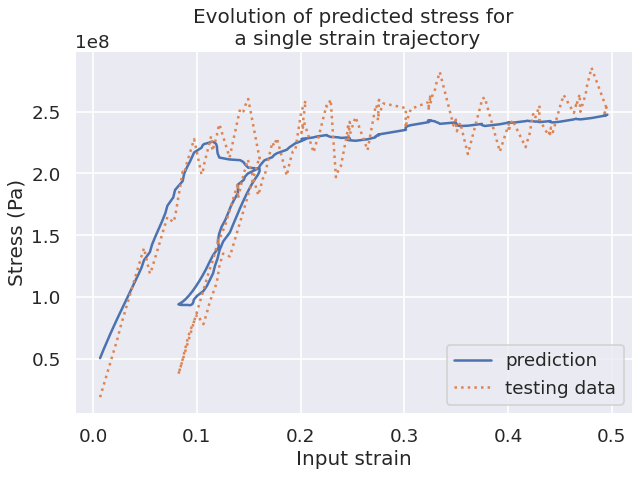

In [0]:
fig = plt.figure(figsize=(9, 6), dpi= 80)
ax = plt.axes(xlabel='Input strain', ylabel='Stress (Pa)', 
              title="Evolution of predicted stress for\n a single strain trajectory")

# Plot the stress series for the first five quadrature points
#plt.plot(X_test_new[0,:,0].T, yhat_new[0,:,0].T, label="without oscillation (not from the same simulation)")
plt.plot(X_test[0,:,0].T, yhat[0,:,0].T, linestyle='-', label="prediction")
plt.plot(X_test[0,:,0].T, y_test[0,:,0].T, linestyle=':', label="testing data")

plt.legend()

## 9 Plotting for presentation

In [0]:
# setting style
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale=1.0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


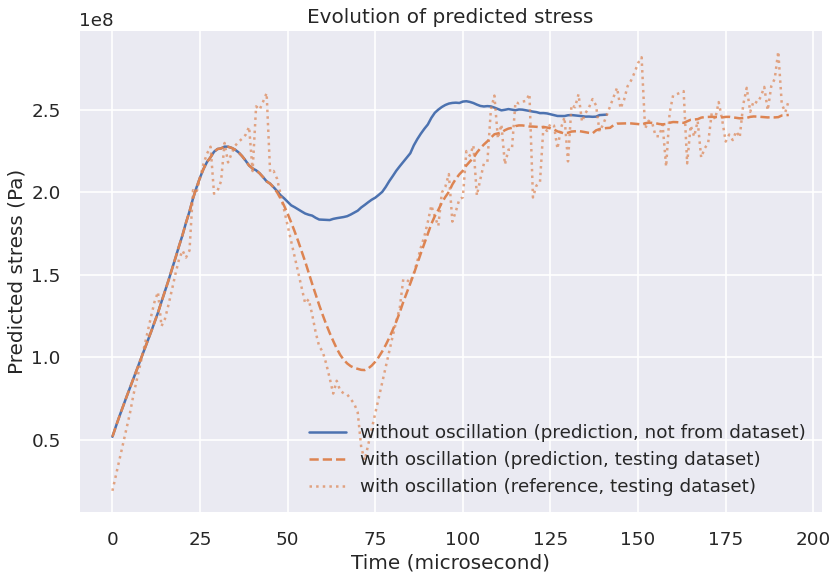

In [0]:
fig = plt.figure(figsize=(12, 8), dpi= 80)
axes = plt.axes(xlabel='Time (microsecond)', ylabel='Predicted stress (Pa)', 
              title="Evolution of predicted stress")

# Plot the stress series for the first five quadrature points
fig = plt.plot(yhat[0,:,0].T, linestyle='--', label="with oscillation (prediction, testing dataset)")
fig = plt.plot(y_test[0,:,0].T, linestyle=':', alpha=0.7, color=fig[-1].get_color(), label="with oscillation (reference, testing dataset)")

plt.legend()

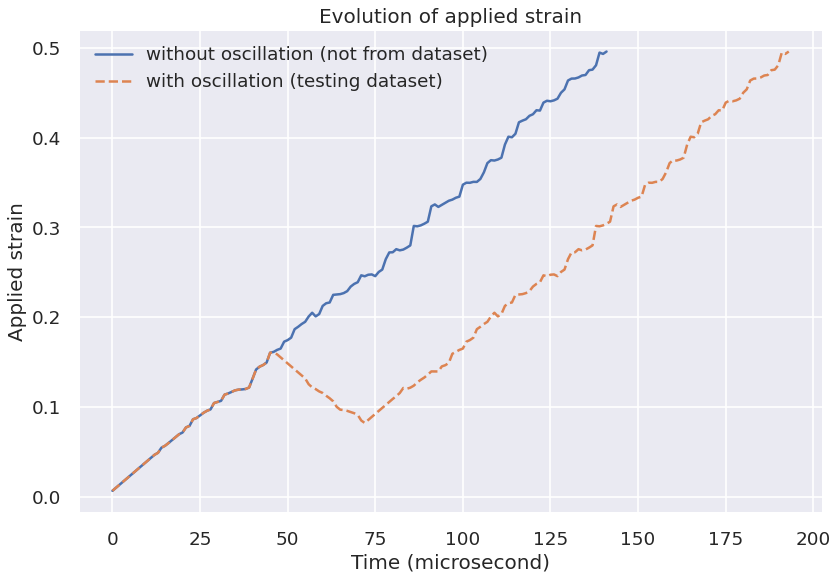

In [0]:
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale=1.0)

fig, axes = plt.subplots(figsize=(12, 8), dpi= 80)
axes = plt.axes(xlabel='Time (microsecond)', ylabel='Applied strain', 
              title="Evolution of applied strain")

# Plot the stress series for the first five quadrature points
plt.plot(X_test_new[0,:,0].T, label="without oscillation (not from dataset)")
plt.plot(X_test[0,:,0].T, linestyle='--', label="with oscillation (testing dataset)")
#plt.plot(X_test[0,:,0].T, linestyle=':', label="with oscillation (testing dataset)")

plt.legend()